In [1]:
import numpy as np

In [9]:
u_train = np.load('u_train.npy')
output_train = np.load('output_train.npy')

[5. 5. 5. ... 5. 5. 5.]


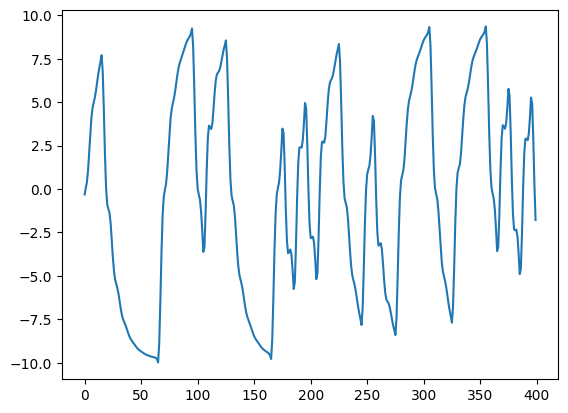

In [34]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def create_arx_regressor(y, u, n, m, d):
    N = len(y)
    p = max(n, d + m)
    
    X = []
    Y = []
    
    for k in range(p, N):
        # Past values of y(k), autoregressive part
        y_lags = [-y[k - i] for i in range(1, n + 1)]
        
        # Past values of u(k), exogenous input part
        u_lags = [u[k - d - j] for j in range(m + 1)]
        
        # Combine both sets of lags into a single row
        X.append(y_lags + u_lags)
        Y.append(y[k])
    
    return np.array(X), np.array(Y)

u_train = np.load('u_train.npy')
y_train = np.load('output_train.npy')
u_test = np.load('u_test.npy')

# Define model orders
n, m, d = 3, 2, 4  # You can experiment with these values

# Create the regressor matrix for the training set
X_train, Y_train = create_arx_regressor(y_train, u_train, n, m, d)


# Train the ARX model using linear regression
model = LinearRegression()
model.fit(X_train, Y_train)

# Predict the test output
y_pred_test = []
y_prev = list(y_train[-n:])  # Initialize with the last known outputs from training

for k in range(len(u_test)):
    # Create the regressor for the current test sample
    if k < d + m:
        # If not enough data for lagged inputs, skip (this happens at the beginning of test set)
        continue
    
    # Predict using the past values of y and u
    y_lags = [-y_prev[-i] for i in range(1, n + 1)]
    u_lags = [u_test[k - d - j] for j in range(m + 1)]
    
    X_test_sample = np.array(y_lags + u_lags).reshape(1, -1)
    
    # Predict the next output
    y_next = model.predict(X_test_sample)[0]
    y_pred_test.append(y_next)
    
    # Update the previous values of y for the next iteration
    y_prev.append(y_next)

# Extract the last 400 predictions (indices 110 to 509)
y_pred_test_last_400 = np.array(y_pred_test[-400:])

# Save the predictions in the required format
np.save('y_pred_test_last_400.npy', y_pred_test_last_400)

plt.plot(y_pred_test_last_400)